# Project 2
Keara Hayes, Atticus Chong, Evelyn Fuhrman

In [35]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
import math
import matplotlib.pyplot as plt
import astropy.constants as _ac
import astropy.units as _au
from numpy import pi
from scipy import optimize

# Useful Code from Project 1
<br><br>Bring back rk4 from the first project to be used in `integrate()`.

In [3]:
def rk4(f,t,z,h,args=()):
    """    
    Arguments
        f(t,z,...)
            function that contains the RHS of the equation dz/dt = f(t,z,...)
    
        t (scalar)
            current time
            
        z (array-like)
            function value
            
        h (scalar)
            step size
    
        args (tuple, optional)
            additional arguments to pass to f
    
    Returns
        znew = z(t+h)
    """
   
    if not isinstance(args,tuple):
        args = (args,)

    k1 = f(t, z, *args)

    k2 = f(t + h/2, z + (h/2)*k1, *args)

    k3 = f(t + h/2, z + (h/2)*k2, *args)

    k4 = f(t + h, z + h*k3, *args)
    
    return z + (h/6)*(k1 + 2*k2 + 2*k3 + k4)

# Project 2

> **Part 1**
<br><br>
Import constants from astro_const.py for consistency.
<br>Define other constants to be used in our solutions.

In [4]:
###importing constants

# solar mass, radius, luminosity
Msun = _ac.M_sun.value
Rsun = _ac.R_sun.value
Lsun = _ac.L_sun.value

# physical constants from astropy, all in MKS units
G = _ac.G.value
h = _ac.h.value
hbar = _ac.hbar.value
m_e = _ac.m_e.value
m_p = _ac.m_p.value
m_n = _ac.m_n.value
m_u = _ac.u.value
c = _ac.c.value
kB = _ac.k_B.value
pc = _ac.pc.value
au = _ac.au.value
year = _au.year.to(_au.second)
sigmaSB = _ac.sigma_sb.value

# other constants
mue = 2
K_e = ((1/5)*((3/(8*pi))**(2/3))*(h**2/(m_e * m_u**(5/3))))

> **Part 2**
<br><br>
Define two functions, `pressure()` and `density()`, to be used throughout the notebook. Test them with `test_eos()`.
<br><br>
`pressure()`: Given a density $\rho$ and mass density $\mu_e$, calculate pressure: $P = ( \,\frac{1}{5}) \,( \,\frac{3}{8\pi}) \,^\frac{2}{3}( \,\frac{h^2}{m_e}) \,( \,\frac{\rho}{\mu_{e}m_u}) \,$
<br><br>
`density()`: Given a pressure $P$ and mass density $\mu_e$, calculate the desntiy: $\rho = \mu_{e}m_u( \,(\,\frac{5Pm_e}{h^2})\,( \,\frac{3}{8\pi}) \,^\frac{-2}{3}) \,^\frac{3}{5}$

In [5]:
def pressure(rho, mue):
    """
    Arguments
        rho
            mass density (kg/m**3)
        mue
            baryon/electron ratio
    
    Returns
        electron degeneracy pressure (Pascal)
    """

    p = (1/5)*(3/(8*np.pi))**(2/3)*(h**2/m_e)*(rho/(mue*m_u))**(5/3)
    return p

In [ ]:
def density(p, mue):
    """
    Arguments
        p
            electron degeneracy pressure (Pascal)
        mue
            baryon/electron ratio  
        mu
            amu
        h
            Planck's constant
        me
            electron mass
        
    Returns
        mass density (kg/m**3)
    """
    
    
    rho = mue*m_u*((5*p*(m_e/h**2)*(3/(8*np.pi))**(-2/3))**(3/5))
    return rho

In [6]:
def test_eos(pressure_func,density_func,mue=2.0,tolerance=1.0e-12,
        testfile='eos_table.txt',units='MKS'):
    """
    compares pressure and density functions against tabulated values

    Arguments
        pressure_func
            function that computes pressure given density and mue
        density_func
            function that computes density given pressure and mue
        mue
            baryon/electron ratio (default = 2.0)
        tolerance
            differences between computed and tabulated EOS values that are 
            larger than tolerance will trigger a warning (default = 1.0e-12)
        testfile
            table of density (kg/m**3), pressure (Pa), and Fermi energy 
            (electron rest mass-energy). Values computed by the eos module are              compared against this (default = 'eos_table.txt')
        units (either 'MKS' or 'CGS')
            specifies either MKS (default) or CGS units

    Returns
        True if all tests passed, False otherwise
    """

    accept = True
    
    # load data, ignoring column containing Fermi energy/(m_e c**2)
    data = np.loadtxt(testfile,skiprows=3,usecols=[0,1])
    density_val = data[:,0]
    pressure_val = data[:,1]

    # conversion factors if eos outputs cgs units
    density_mks_to_cgs = 1.0e-3
    pressure_mks_to_cgs = 10.0
    if units.lower()=='cgs':
        density_val *= density_mks_to_cgs
        pressure_val *= pressure_mks_to_cgs

    # table header
    print(
        '{0:>14}{1:>14}{2:>14}  {3:>14}{4:>14}{5:>14}\n'.format(
            'rho (table)','rho (test)','difference',
            'P (table)','P (test)','difference'))

    # iterate over density, pressure values and test individually
    for rho, p in zip(density_val, pressure_val):
        Ptest = pressure_func(rho,mue)
        rhotest = density_func(p,mue)
        Perr = (Ptest-p)/p
        rhoerr = (rhotest-rho)/rho
        print(
            '{0:14.6e}{1:14.6e}{2:14.6e}  {3:14.6e}{4:14.6e}{5:14.6e}'.\
            format(rho,rhotest,rhoerr,p,Ptest,Perr))

        if max(abs(Perr),abs(rhoerr)) > tolerance:
            print('******** value outside accepted tolerance ********\n')
            accept = False
            
    return accept


if __name__ == "__main__":

    print('Comparing EOS to eos_table.txt...\n')
    if (test_eos(pressure,density)):
        print('\nSUCCESS: all values within tolerance')
    else:
        print('\nFAIL')


Comparing EOS to eos_table.txt...



NameError: name 'density' is not defined

> **Part 3**
<br><br>
Define `stellar_derivatives()` to compute the RMS of equations (4) and (5)

In [8]:
def stellar_derivatives(m,z,mue):
    """
    RHS of Lagrangian differential equations for radius and pressure
    
    Arguments
        m
            current value of the mass
        z (array)
            current values of (radius,pressure)
        mue
            ratio, nucleons to electrons. For a carbon-oxygen white dwarf, mue = 2.
        
    Returns
        dzdm (array)
            Lagrangian derivatives dr/dm, dP/dm
    """
    
    dzdm = np.zeros_like(z)
    
    dzdm[0] = (4*pi*(z[0]**2)*density(z[1],mue))**(-1)
    dzdm[1] = (-G*m)/(4*pi*(z[0]**4))
    
    return dzdm

> **Part 4**
<br><br>
Define `central_values()` to find the central boundary conditions of the white dwarf.

In [10]:
density(1,2)

0.00012591999558046895

In [11]:
def central_values(Pc,delta_m,mue):
    """
    Constructs the boundary conditions at the edge of a small, constant density 
    core of mass delta_m with central pressure P_c
    
    Arguments
        Pc
            central pressure (units = ?)
        delta_m
            core mass (units = ?)
        mue
            nucleon/electron ratio
    
    Returns
        z = array([ r, p ])
            central values of radius and pressure (units = ?)
    """
    z = np.zeros(2)
    
    z[0] = ((3*delta_m)/(4 * np.pi * density(Pc, mue)))**1/3
    z[1] = Pc   
    return z

> **Part 5**
<br><br>
Define `lengthscales()` and `integrate()` to integrate our structure equations. 

In [12]:
def lengthscales(m,z,mue):
    """
    Computes the radial length scale H_r and the pressure length H_P
    
    Arguments
        m
            current mass coordinate (units = ?)
        z (array)
           [ r, p ] (units = ?)
        mue
            mean electron weight
    
    Returns
        z/|dzdm| (units = ?)
    """    
    
    radius = z[0]
    pressure = z[1]
    rho = density(pressure, mue)
    H_r = 4 * np.pi * (radius**3) * rho
    H_p = (4 * np.pi * (radius**4) * pressure) / (G * m) 
    
    out = [H_r, H_p]
    
    out = np.asarray(out)
    
    return out

In [13]:
def integrate(Pc,delta_m,eta,xi,mue,max_steps=10000):
    """
    Integrates the scaled stellar structure equations

    Arguments
        Pc
            central pressure (units = ?)
        delta_m
            initial offset from center (units = ?)
        eta
            The integration stops when P < eta * Pc
        xi
            The stepsize is set to be xi*min(p/|dp/dm|, r/|dr/dm|)
        mue
            mean electron mass
        max_steps
            solver will quit and throw error if this more than max_steps are 
            required (default is 10000)
                        
    Returns
        m_step, r_step, p_step
            arrays containing mass coordinates, radii and pressures during 
            integration (what are the units?)
    """
        
    m_step = np.zeros(max_steps)
    r_step = np.zeros(max_steps)
    p_step = np.zeros(max_steps)
  
    # set starting conditions using central values
    temp = delta_m
    z = central_values(Pc, delta_m, mue)
    Nsteps = 0
    
    for step in range(max_steps):
        radius = z[0]
        pressure = z[1]
        
        # are we at the surface?
        if (pressure < eta*Pc):
            break
            
        # store the step
        m_step[step] = temp
        r_step[step] = radius
        p_step[step] = pressure
        
        # set the stepsize
#         H_r, H_p = lengthscales(m_step[step], z, mue)
        h = xi*min(lengthscales(m_step[step], z, mue))

        # take a step
        z = rk4(stellar_derivatives,temp,z,h,args=(mue))
        temp += h
        
        # increment the counter
        Nsteps += 1
    # if the loop runs to max_steps, then signal an error
    else:
        raise Exception('too many iterations')
        
    return m_step[0:Nsteps],r_step[0:Nsteps],p_step[0:Nsteps]

> **Part 6**
<br><br>
Given a trial mass value and integration parameters $\delta_m$, $\xi$, and $n$, compute a guess for central pressure $P_{c}^{guess}$. Adjust integration parameters one at a time until we reach a converged value for the mass and radius. Then adjust $P_c$ until we find a lower and upper range value for pressure that will produce masses in the range of (0.1 to 1.0) $M_{\odot}$


In [14]:
def guess_P_c(M, mue):
    return ((G**5)/(K_e**4))*((M*(mue**2))**(10/3))

In [15]:
P_c_guess=guess_P_c(Msun, mue)

In [16]:
delta_m = 1e-4
eta = 1e-20
xi = 0.05

In [17]:
integrate(P_c_guess,delta_m,eta,xi,mue,max_steps=10000)


(array([1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
        6.01769068e+30, 6.01769068e+30, 6.01769068e+30]),
 array([2.13839360e-16, 2.24037272e-16, 2.34721519e-16, ...,
        6.13816878e+06, 6.13816878e+06, 6.13816878e+06]),
 array([1.31123234e+24, 1.31123234e+24, 1.31123234e+24, ...,
        1.48085866e+04, 1.40681573e+04, 1.33647494e+04]))

> **Part 7**

In [18]:
masses = np.arange(0.1, 1, 0.1)*Msun
pcs = []

m_step, r_step, p_step = integrate(P_c_guess,delta_m,eta,xi,mue)

def mass_diff(Pc, m_want, delta_m, eta, mue):
    
    m_step, r_step, p_step = integrate(Pc,delta_m,eta,xi,mue)

    diff = m_step[-1] - m_want
    
    return diff

for i in masses:
    
    out = optimize.bisect(mass_diff, a = 1e19, b = 1e23, xtol=1e-6, args = (i, delta_m, eta, mue))
    
    pcs.append(out)
    

In [21]:
pcs

[1.5179815171545375e+19,
 1.5300294946247662e+20,
 5.911132103104252e+20,
 1.542173093187189e+21,
 3.2446398532427967e+21,
 5.958047819643775e+21,
 9.96001403872837e+21,
 1.5544130718675136e+22,
 2.301838494376299e+22]

In [41]:
df = pd.DataFrame()

df[r'$\frac{M}{M_{\odot}}$'] = masses / Msun
df[r'$\frac{R}{0.01R_{\odot}}$'] = radii / (Rsun*0.01)
df[r'$P_c (MKS)$'] = pcs
df[r'$\frac{P_c}{(GM^2R^{-4})}$'] = pcs / (G * (masses**2) * (radii**(-4)))
df[r'$\rho (MKS)$'] = masses / (radii**3)
df[r'$\frac{\rho_{c}}{[\frac{3M}{4\pi R^3}]}$'] = (3 * masses) / (4 * np.pi * (radii**3))

df

,$\frac{M}{M_{\odot}}$,$\frac{R}{0.01R_{\odot}}$,$P_c (MKS)$,$\frac{P_c}{(GM^2R^{-4})}$,$\rho (MKS)$,$\frac{\rho_{c}}{[\frac{3M}{4\pi R^3}]}$
0,0.1,1.725187,1.517982e+19,0.119366,1.150089e+08,2.745636e+07
1,0.2,1.369282,1.530029e+20,0.119366,4.600357e+08,1.098254e+08
2,0.3,1.196178,5.911132e+20,0.119366,1.035080e+09,2.471072e+08
3,0.4,1.086800,1.542173e+21,0.119366,1.840143e+09,4.393018e+08
4,0.5,1.008895,3.244640e+21,0.119366,2.875223e+09,6.864090e+08
5,0.6,0.949407,5.958048e+21,0.119366,4.140322e+09,9.884290e+08
6,0.7,0.901855,9.960014e+21,0.119366,5.635438e+09,1.345362e+09
7,0.8,0.862593,1.554413e+22,0.119366,7.360572e+09,1.757207e+09
8,0.9,0.829383,2.301838e+22,0.119366,9.315723e+09,2.223965e+09


> **Part 8**

In [22]:
import matplotlib.pyplot as plt
from observations import MassRadiusObservations

obs = MassRadiusObservations()

print(f"Masses:\n {obs.masses}\n\nRadii:\n {obs.radii}\n\nRadius Errors:\n {obs.radius_errors}\n\n")

for source, info in obs.sources.items():
    print('{0:20} M = {1:5.3f} +/- {2:5.3f} Msun'.format(source, info.mass, info.mass_error))

Masses:
 [0.927 0.607 0.643 0.541 0.59  0.398 0.277 0.729 0.543 0.723 0.559 0.524
 0.633 0.376]

Radii:
 [0.802 1.461 1.457 1.34  1.378 1.418 1.464 1.235 1.42  1.717 2.183 1.452
 1.993 1.504]

Radius Errors:
 [0.011 0.009 0.036 0.013 0.011 0.009 0.018 0.018 0.014 0.009 0.043 0.024
 0.009 0.042]


Sirius B-HST         M = 0.927 +/- 0.107 Msun
HZ43-HST             M = 0.607 +/- 0.106 Msun
HZ43-FUSE            M = 0.643 +/- 0.065 Msun
14 Aur Cb-HST        M = 0.541 +/- 0.086 Msun
14 Aur Cb-FUSE       M = 0.590 +/- 0.028 Msun
HD2133 B-HST         M = 0.398 +/- 0.138 Msun
HD2133 B-FUSE        M = 0.277 +/- 0.069 Msun
HR1358 B-HST         M = 0.729 +/- 0.053 Msun
RE 0357-FUSE         M = 0.543 +/- 0.039 Msun
HD 223816-FUSE       M = 0.723 +/- 0.019 Msun
RE 1024-FUSE         M = 0.559 +/- 0.030 Msun
REJ 1925-FUSE        M = 0.524 +/- 0.040 Msun
Feige 24-FUSE        M = 0.633 +/- 0.012 Msun
HD15638-FUSE         M = 0.376 +/- 0.026 Msun


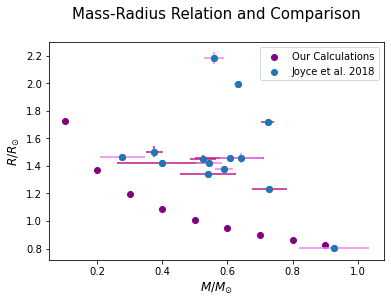

In [34]:
radii = (((3/(8*np.pi)) * G * ((masses**2)/pcs)))**((1/4))

solar_masses = masses / Msun
solar_radii = radii / (Rsun*0.01)

plt.scatter(solar_masses, solar_radii, label = 'Our Calculations', color = 'purple')
plt.scatter(obs.masses, obs.radii, label = 'Joyce et al. 2018')
plt.errorbar(obs.masses, obs.radii, xerr=obs.mass_errors, yerr=obs.radius_errors, fmt='o', 
             ecolor = ['violet', 'mediumvioletred'])

plt.title(f'Mass-Radius Relation and Comparison\n', fontsize=15)
axes_fontsize = 12
plt.xlabel(r'$M/M_{\odot}$', fontsize = axes_fontsize);
plt.ylabel(r'$R/R_{\odot}$', fontsize = axes_fontsize);
plt.legend();